In [ ]:
import os
import numpy as np
from collections import Counter
from tf_keras.models import Model, Sequential 
from tf_keras.layers import (Input, Conv2D, MaxPooling2D,
                                     GlobalAveragePooling2D, Dense,
                                     Dropout, ConvLSTM2D, TimeDistributed,
                                     Flatten)
from tf_keras.optimizers import Adam
from tf_keras.utils import to_categorical
from tf_keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = (224, 224) # resize images
BATCH_SIZE = 8
EPOCHS = 50 # train for 50 iterations
LEARNING_RATE = 0.001
SEQUENCE_LENGTH = 5 # 5 frames per video

In [14]:
DATA_DIR = "/content/drive/MyDrive/Exercise Tracking/Augmented Exercise Frames"

In [ ]:
LABELS = ["Head Rotation", "Head Turns", "Neck Extension", "Neck Side Bend", "Neck Stretch", "Shoulder Shrug"] # 6 exercise classes

In [ ]:
def load_data(data_dir):
    images, labels = [], []

    # Iterate through each class folder
    for class_name in os.listdir(data_dir):
        class_folder = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_folder):
            continue

        # Iterate through subfolders within each class folder
        for subfolder in os.listdir(class_folder):
            subfolder_path = os.path.join(class_folder, subfolder)
            if not os.path.isdir(subfolder_path):
                continue

            # Iterate through image files in the subfolder
            for file in os.listdir(subfolder_path):
                if file.endswith(".jpg") or file.endswith(".png"):
                    image_path = os.path.join(subfolder_path, file)
                    image = load_img(image_path, target_size=IMAGE_SIZE) # Resize image
                    image = img_to_array(image) / 255.0  # Normalize pixel values
                    images.append(image)
                    labels.append(class_name)

    print(f"Loaded {len(images)} images with shape {np.array(images).shape}.")
    return np.array(images), np.array(labels)

In [17]:
def balance_classes(images, labels):
    label_counts = Counter(labels)
    print(f"Class distribution before balancing: {label_counts}")

    max_count = max(label_counts.values())
    images_balanced, labels_balanced = [], []

    for label in label_counts.keys():
        # Get images and labels of the current class
        class_indices = np.where(labels == label)[0]
        class_images = images[class_indices]
        class_labels = labels[class_indices]

        # If the class already has the maximum count, just add them
        if len(class_images) == max_count:
            images_balanced.extend(class_images)
            labels_balanced.extend(class_labels)
        else:
            # Oversample minority classes
            oversampled_images = resample(
                class_images,
                n_samples=max_count,
                replace=True,
                random_state=42
            )
            oversampled_labels = [label] * max_count  # Create labels for oversampled data
            images_balanced.extend(oversampled_images)
            labels_balanced.extend(oversampled_labels)

    # Shuffle the balanced dataset
    images_balanced, labels_balanced = shuffle(np.array(images_balanced), np.array(labels_balanced), random_state=42)
    print(f"Class distribution after balancing: {Counter(labels_balanced)}")
    return images_balanced, labels_balanced

In [ ]:
def create_sequences(images, labels, sequence_length): # group frames into sequences
    sequences, sequence_labels = [], []
    for i in range(0, len(images) - sequence_length + 1, sequence_length):
        sequences.append(images[i:i + sequence_length])
        sequence_labels.append(labels[i])
    return np.array(sequences), np.array(sequence_labels)

In [19]:
def build_convlstm_model(input_shape, num_classes):
    model = Sequential([
        ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='relu',
                   return_sequences=False, input_shape=input_shape),
        Dropout(0.3),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [20]:
images, labels = load_data(DATA_DIR)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
images_balanced, labels_balanced = balance_classes(images, labels_encoded)

Loaded 1031 images with shape (1031, 224, 224, 3).
Class distribution before balancing: Counter({3: 279, 1: 193, 0: 193, 4: 170, 5: 156, 2: 40})
Class distribution after balancing: Counter({5: 279, 4: 279, 0: 279, 2: 279, 3: 279, 1: 279})


In [21]:
sequences, sequence_labels = create_sequences(images_balanced, labels_balanced, SEQUENCE_LENGTH)
sequence_labels_categorical = to_categorical(sequence_labels, num_classes=len(LABELS))
X_train, X_test, y_train, y_test = train_test_split(
    sequences, sequence_labels_categorical, test_size=0.2, random_state=42
)

In [22]:
input_shape = (SEQUENCE_LENGTH, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
model = build_convlstm_model(input_shape, num_classes=len(LABELS))

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/50
34/34 [==============================] - 18s 280ms/step - loss: 9.2085 - accuracy: 0.1760 - val_loss: 1.8330 - val_accuracy: 0.1343
Epoch 2/50
34/34 [==============================] - 8s 248ms/step - loss: 1.7940 - accuracy: 0.1610 - val_loss: 1.7937 - val_accuracy: 0.1343
Epoch 3/50
34/34 [==============================] - 9s 253ms/step - loss: 1.7832 - accuracy: 0.2210 - val_loss: 1.7899 - val_accuracy: 0.1343
Epoch 4/50
34/34 [==============================] - 9s 255ms/step - loss: 1.7471 - accuracy: 0.2472 - val_loss: 1.7655 - val_accuracy: 0.1493
Epoch 5/50
34/34 [==============================] - 9s 252ms/step - loss: 1.7223 - accuracy: 0.2397 - val_loss: 1.7959 - val_accuracy: 0.1493
Epoch 6/50
34/34 [==============================] - 8s 250ms/step - loss: 1.7619 - accuracy: 0.1985 - val_loss: 1.7891 - val_accuracy: 0.1642
Epoch 7/50
34/34 [==============================] - 8s 247ms/step - loss: 1.7550 - accuracy: 0.2210 - val_loss: 1.7822 - val_accuracy: 0.1642
Epoch

In [23]:
model.save("tracking_model.h5")

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


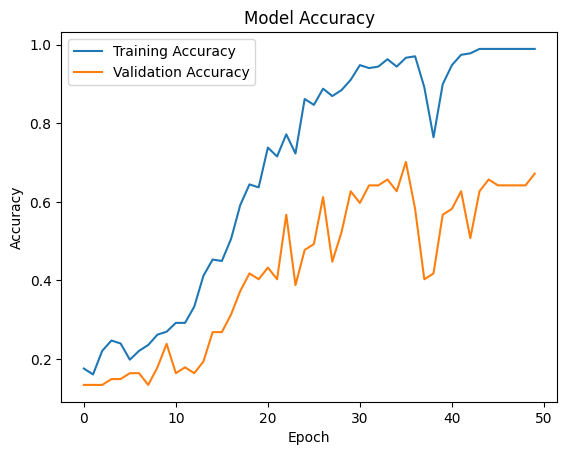

In [24]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

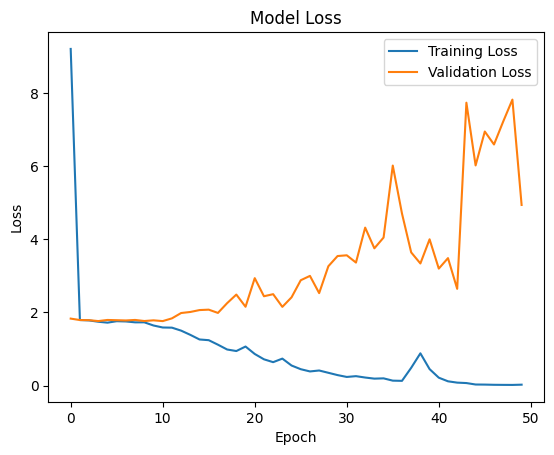

In [25]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()